# Определение стоимости автомобилей

# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель исследования**: построить модель для определения стоимости автомобилей. 

Критерии, важные для заказчика:

- качество предсказания;
- скорость предсказания;
- время обучения.

Импортируем библиотеки:

In [1]:
!pip install phik -q
!pip install scikit-learn==1.5.0 -q
!pip install optuna -q

import sklearn
import re
import phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import optuna

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoost, CatBoostRegressor
import lightgbm as lgb

from lightgbm import early_stopping

RANDOM_STATE=42

## Подготовка данных

### Загрузка данных, изучение информации

Загружаем данные и сохраняем в датарейм df_autos:

In [2]:
df_autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
display(df_autos.sample(5))
df_autos.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
35529,2016-03-28 15:25:22,6450,small,2012,auto,71,fortwo,50000,6,petrol,smart,no,2016-03-28 00:00:00,0,60431,2016-04-06 23:46:15
279210,2016-03-08 21:39:02,1750,wagon,2000,auto,230,other,150000,7,petrol,saab,no,2016-03-08 00:00:00,0,12157,2016-03-17 07:15:51
114747,2016-03-26 11:38:41,8699,wagon,2008,manual,143,3er,150000,11,gasoline,bmw,no,2016-03-26 00:00:00,0,63322,2016-04-02 00:19:00
327016,2016-03-20 11:55:49,800,wagon,1999,manual,150,3er,150000,11,petrol,bmw,no,2016-03-20 00:00:00,0,57578,2016-04-06 16:47:03
282426,2016-03-27 16:39:00,1950,bus,2004,manual,103,other,150000,8,petrol,hyundai,no,2016-03-27 00:00:00,0,46147,2016-04-05 11:47:35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Описание данных**:

- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л.с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя;
- Price — цена (евро) - целевой признак.

**Вывод**: 

В датафрейме 354369 строк, 16 столбцов. Имеются пропуски, неверные типы данных и некорректная запись названий столбцов.

###  Предобработка данных

Для дальнейшего контроля доли удаленных данных от исходного датасета, скопируем исходный датасет в df_autos_control:

In [4]:
df_autos_control = df_autos.copy()

#### Корректировка записи названий столбцов

Приводим к нижнему регистру названия столбцов в датафрейме df_autos, добавляем "_" между словами:

In [5]:
df_autos.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in df_autos.columns]
print(f'''Проверяем изменения: 
    {df_autos.columns.unique()}
    ''')

Проверяем изменения: 
    Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')
    


**Вывод:** названия столбцов приведены к "змеиному" регистру.

#### Проверка наличия явных дубликатов

In [6]:
print(f'''Количество явных дубликатов: 
    {df_autos.duplicated().sum()}
    ''')

Количество явных дубликатов: 
    4
    


В датафрейме обнаружены явные дубликаты. Удаляем их и заменяем старые индексы на новые: 

In [7]:
df_autos = df_autos.drop_duplicates().reset_index(drop=True)

print(f'''Проверяем удаление. Количество явных дубликатов: 
    {df_autos.duplicated().sum()}
    ''')

Проверяем удаление. Количество явных дубликатов: 
    0
    


**Вывод:** явняе дубликаты (4 строки) удалены.

#### Проверка наличия неявных дубликатов, ошибок

Выводим уникальные значения для проверки наличия неявных дубликатов, ошибок:

In [8]:
print(f'''Уникальные значения в:

df_autos['vehicle_type']: {df_autos['vehicle_type'].unique()}

df_autos['gearbox']: {df_autos['gearbox'].unique()}

df_autos['model']: {df_autos['model'].unique()}

df_autos['fuel_type']: {df_autos['fuel_type'].unique()}

df_autos['brand']: {df_autos['brand'].unique()}

df_autos['repaired']: {df_autos['repaired'].unique()}
''')

Уникальные значения в:

df_autos['vehicle_type']: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

df_autos['gearbox']: ['manual' 'auto' nan]

df_autos['model']: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fo

В столбце 'fuel_type' (тип топлива) обнаружен неявный дубликат: 'petrol' и 'gasoline' - это два разных названия для одного и того же топлива, бензина. 'gasoline' чаще используется в Северной Америке, а 'petrol' - в других странах. Заменим значение 'gasoline' на 'petrol' в датафрейме:

In [9]:
df_autos['fuel_type'] = df_autos['fuel_type'].str.replace('gasoline', 'petrol')

print(f'''Проверяем замену. Уникальные значения в столбце: 
    {df_autos['fuel_type'].unique()}
    ''')

Проверяем замену. Уникальные значения в столбце: 
    ['petrol' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
    


В столбце 'model' (модель автомобиля) обнаружен неявный дубликат: 'rangerover' и 'range_rover' - это два разных названия для одного и того же. Заменим значение 'rangerover' на 'range_rover' в датафрейме:

In [10]:
df_autos['model'] = df_autos['model'].str.replace('rangerover', 'range_rover')

print(f'''Проверяем замену. Уникальные значения в столбце: 
    {df_autos['model'].unique()}
    ''')

Проверяем замену. Уникальные значения в столбце: 
    ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis

Проверим наличие полных дубликатов после замены:

In [11]:
print(f'''Количество явных дубликатов: 
    {df_autos.duplicated().sum()}
    ''')

Количество явных дубликатов: 
    0
    


**Вывод**: обнаружены неявные дубликаты в столбце 'fuel_type' (тип топлива): 'petrol' и 'gasoline' - это два разных названия для одного и того же топлива, бензина ('gasoline' чаще используется в Северной Америке, а 'petrol' - в других странах). Значение 'gasoline' заменено на 'petrol'. В столбце 'model' (модель автомобиля) обнаружен неявный дубликат: 'rangerover' и 'range_rover' - это два разных названия для одного и того же. Заменено значение 'rangerover' на 'range_rover'.

#### Удаление ненужных данных

Для моделирования не потребуются такие данные:
- date_crawled — дата скачивания анкеты из базы;
- date_created — дата создания анкеты;
- number_of_pictures — количество фотографий автомобиля;
- postal_code — почтовый индекс владельца анкеты (пользователя);
- registration_month - месяц регистрации автомобиля;
- last_seen — дата последней активности пользователя.

Данные столбцы удаляем из датафрейма:

In [12]:
df_autos = df_autos.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 
                          'last_seen', 'registration_month'], axis=1)

df_autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


In [13]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


После удаления ненужных данных остались столбцы с верным типом данных. Изменение типов данных уже не требуется.

#### Проверка наличия пропущенных значений

In [14]:
print(f'''Количество пропущенных значений: 
    {df_autos.isna().sum()}
    ''')

Количество пропущенных значений: 
    price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64
    


**Cтолбец 'vehicle_type' - тип кузова**.

In [15]:
df_autos['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заменим пропуски на значение 'other':

In [16]:
df_autos['vehicle_type'].fillna('other', inplace=True)

print(f'''Проверяем замену. Уникальные значения в столбце: 
    {df_autos['vehicle_type'].unique()}
    ''')

Проверяем замену. Уникальные значения в столбце: 
    ['other' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon']
    


**Cтолбец 'gearbox' - тип коробки передач**.

In [17]:
df_autos['gearbox'].value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

Заменим пропуски на значение 'manual' как на наиболее часто встречающееся значение:

In [18]:
df_autos['gearbox'].fillna('manual', inplace=True)

print(f'''Проверяем замену. Уникальные значения в столбце: 
    {df_autos['gearbox'].unique()}
    ''')

Проверяем замену. Уникальные значения в столбце: 
    ['manual' 'auto']
    


**Cтолбец 'model' - модель автомобиля**.

In [19]:
df_autos['model'].isna().sum()

19705

Пропусков слишком много, заменим их на значение 'unknown':

In [20]:
df_autos['model'].fillna('unknown', inplace=True)

print(f'''Проверяем замену. Уникальные значения в столбце: 
    {df_autos['model'].unique()}
    ''')

Проверяем замену. Уникальные значения в столбце: 
    ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'a

**Cтолбец 'fuel_type' - тип топлива**.

In [21]:
df_autos['fuel_type'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Заменим пропуски на значение 'other':

In [22]:
df_autos['fuel_type'].fillna('other', inplace=True)

print(f'''Проверяем замену. Уникальные значения в столбце: 
    {df_autos['fuel_type'].unique()}
    ''')

Проверяем замену. Уникальные значения в столбце: 
    ['petrol' 'other' 'lpg' 'hybrid' 'cng' 'electric']
    


**Cтолбец 'repaired' - была машина в ремонте или нет**.

In [23]:
df_autos['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Предположим, что пропуски в данных означают то, что владелец автомобиля не захотел "светить" аварийность или прошлые неисправности своего автомобиля, поэтому не заполнил данный пункт в анкете. Т.к. автомобили, бывшие ремонте, ценятся покупателями меньше, т.е. спрос на них снижается, что вызывает понижение цены данного автомобиля. Заменим пропуски на значение 'yes' - автомобиль был в ремонте:

In [24]:
df_autos['repaired'].fillna('yes', inplace=True)

print(f'''Проверяем замену. Уникальные значения в столбце: 
    {df_autos['repaired'].unique()}
    ''')

Проверяем замену. Уникальные значения в столбце: 
    ['yes' 'no']
    


Проверяем наличие пропусков после преобразований:

In [25]:
print(f'''Количество пропущенных значений: 
{df_autos.isna().sum()}
''')

Количество пропущенных значений: 
price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64



**Вывод**: обнаружены пропущенные значения. Выполнены замены пропусков в столбцах:
- 'vehicle_type' - тип кузова - на 'other';
- 'gearbox' - тип коробки передач - на 'manual';
- 'model' - модель автомобиля - на 'unknown';
- 'fuel_type' - тип топлива - на 'other';
- 'repaired' - была машина в ремонте или нет - на 'yes'.

#### Вывод по разделу

**На этапе предобработки данных было выполнено**:

1. **Корректировка записи названий столбцов** - названия столбцов приведены к "змеиному" регистру;
2. **Проверка наличия явных дубликатов** - явные дубликаты (4 строки) удалены;
3. **Проверка наличия неявных дубликатов, ошибок**: 
   - неявные дубликаты в столбце 'fuel_type' (тип топлива): 'petrol' и 'gasoline' - это два разных названия для одного и того же топлива, бензина ('gasoline' чаще используется в Северной Америке, а 'petrol' - в других странах). Значение 'gasoline' заменено на 'petrol';
   - в столбце 'model' (модель автомобиля) обнаружен неявный дубликат: 'rangerover' и 'range_rover' - это два разных названия для одного и того же. Заменено значение 'rangerover' на 'range_rover';
   

4. **Удаление ненужных данных**. Для моделирования не требуются такие данные, удалены:
   - date_crawled — дата скачивания анкеты из базы;
   - date_created — дата создания анкеты;
   - number_of_pictures — количество фотографий автомобиля;
   - postal_code — почтовый индекс владельца анкеты (пользователя);
   - registration_month - месяц регистрации автомобиля;
   - last_seen — дата последней активности пользователя.
   

5. **Проверка наличия пропущенных значений**. В столбцах:
   - 'vehicle_type' - тип кузова. Пропуски заменены на значение 'other';
   - 'gearbox' - тип коробки передач. Пропуски заменены на значение 'manual' как на наиболее часто встречающееся значение;
   - 'model' - модель автомобиля. Пропуски заменены на значение 'unknown';
   - 'fuel_type' - тип топлива. Пропуски заменены на значение 'other';
   - 'repaired' - была машина в ремонте или нет. Пропуски заменены на значение 'yes' - автомобиль был в ремонте, т.к. есть предположение, что владелец автомобиля не захотел "светить" аварийность или прошлые неисправности своего автомобиля, поэтому не заполнил данный пункт в анкете. Т.к. автомобили, бывшие ремонте, ценятся покупателями меньше, т.е. спрос на них снижается, что вызывает понижение цены данного автомобиля.
  

### Исследовательский анализ данных

**Визуализация признаков**

Создаем функцию для построения графиков (гистограмма, диаграмма размаха) количественных непрерывных признаков:

In [26]:
def viz_num_character(column, title, bins):
    sns.set(rc={'figure.figsize': (14, 7)})
    sns.set_palette('PRGn')
    fig, axes = plt.subplots(1, 2)
    sns.histplot(data=df_autos, x=df_autos[column], kde=True, bins=bins, ax=axes[0])
    axes[0].set(ylabel='частота', xlabel=column)
    median_value = df_autos[column].median()
    mean_value = df_autos[column].mean()
    axes[0].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
    axes[0].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
    axes[0].legend()
    sns.boxplot(data=df_autos[column], ax=axes[1])
    axes[1].set(ylabel=column)
    plt.suptitle(title)
    plt.show()

Создаем функцию для построения графиков (столбчатая диаграмма) категориальных признаков и дискретных количественных:

In [27]:
def viz_bar_character(column, title):
    plt.figure(figsize=(14, 8))
    sns.set_palette('PRGn')
    sns.countplot(data=df_autos, y=column)
    plt.xlabel('количество')
    plt.suptitle(title)
    plt.show()

Проведем статистический анализ всех признаков. Числовые характеристики:

In [28]:
df_autos.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


**Вывод**: имеются аномалии. Рассмотрим их подробней.

Определим число "бинов" для данного датафрейма по правилу Стёрджеса: число bins = log2(n) + 1, где n - количество наблюдений. В данном случае 354365 наблюдений, получаем bins = 19.

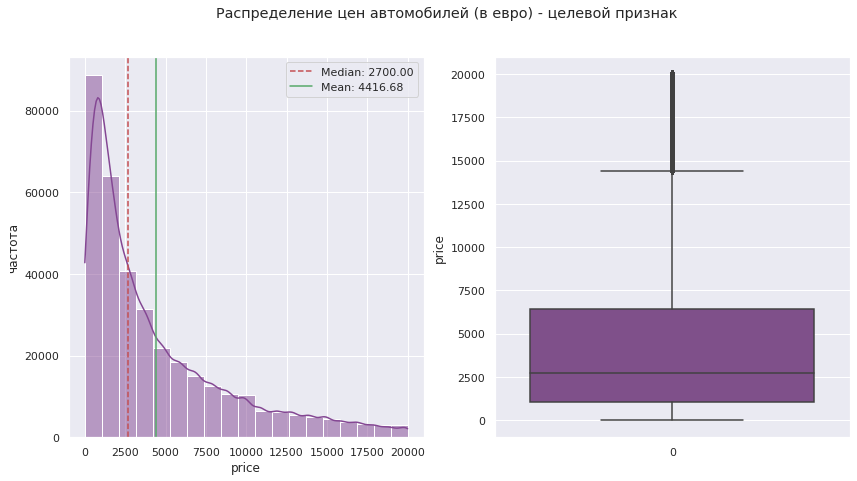

In [29]:
viz_num_character('price', 'Распределение цен автомобилей (в евро) - целевой признак', 19)

Посмотрим строки с ценой автомобилей меньше 50 евро:

In [30]:
df_autos.query('price < 50')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,other,1990,manual,0,corsa,150000,petrol,opel,yes
59,1,suv,1994,manual,286,unknown,150000,other,sonstige_autos,yes
89,1,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no
111,0,other,2017,manual,0,golf,5000,petrol,volkswagen,yes
...,...,...,...,...,...,...,...,...,...,...
354201,0,other,2000,manual,65,corsa,150000,other,opel,yes
354234,0,small,2002,manual,60,fiesta,150000,petrol,ford,yes
354244,0,small,1999,manual,53,swift,150000,petrol,suzuki,yes
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


Посчитаем долю строк с ценой автомобилей меньше 50 евро:

In [31]:
print(f'''Доля автомобилей с ценой, равной нулю: 
    {(len(df_autos.query('price < 50')) / len(df_autos_control)) * 100} %
    ''')

Доля автомобилей с ценой, равной нулю: 
    3.505667820830829 %
    


Доля автомобилей с ценой меньше 50 евро от общего числа автомобилей составляет всего 3,5%. Удалим их. 

In [32]:
df_autos = df_autos.query('price >= 50')

df_autos['price'].describe()

count    341942.000000
mean       4577.108556
std        4514.861088
min          50.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

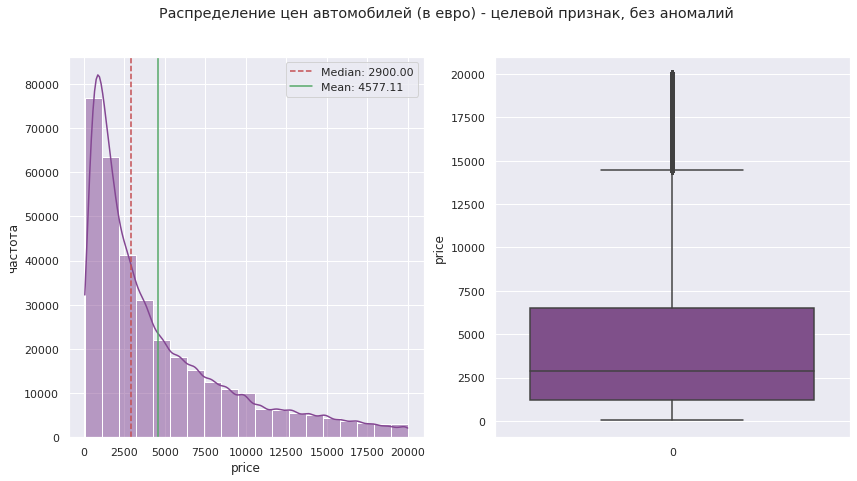

In [33]:
viz_num_character('price', 'Распределение цен автомобилей (в евро) - целевой признак, без аномалий', 19)

**Вывод**: средняя цена автомобиля 4577.11 евро, медиана - 2900 евро. Аномальные значения (цена меньше 50 евро) удалены.

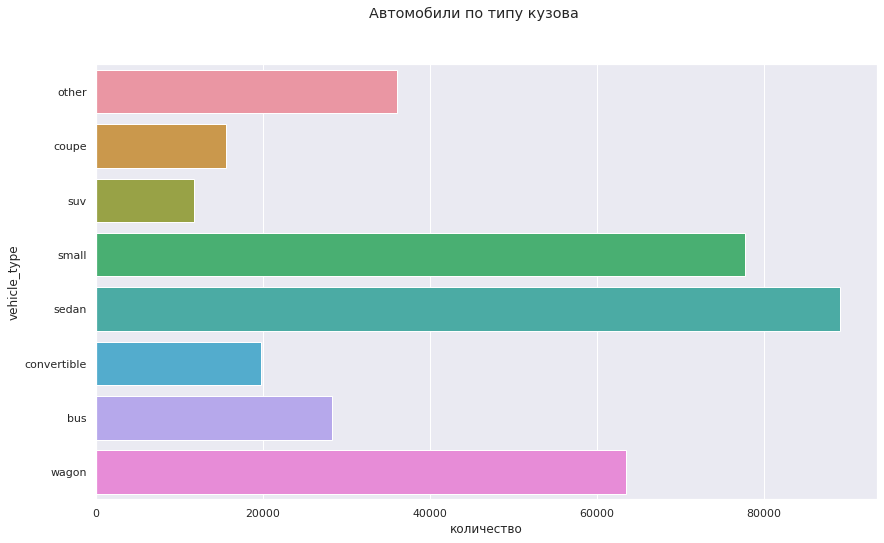

,тип кузова,"доля, %"
0,sedan,26.077229
1,small,22.749765
2,wagon,18.577127
3,other,10.538337
4,bus,8.268069
5,convertible,5.796305
6,coupe,4.552234
7,suv,3.440934


In [34]:
viz_bar_character('vehicle_type', 'Автомобили по типу кузова')

df_autos_vehicle_type = (df_autos['vehicle_type'].value_counts(normalize=True) * 100)
df_autos_vehicle_type.rename_axis('тип кузова').reset_index(name='доля, %')

**Вывод**: больше всего в данных представлено автомобилей с типом кузова седан (sedan) - 26% и хэтчбэки (small) - 22.7%, меньше всего купе (coupe) - 4.55% и внедорожники (suv) - 3.44%.

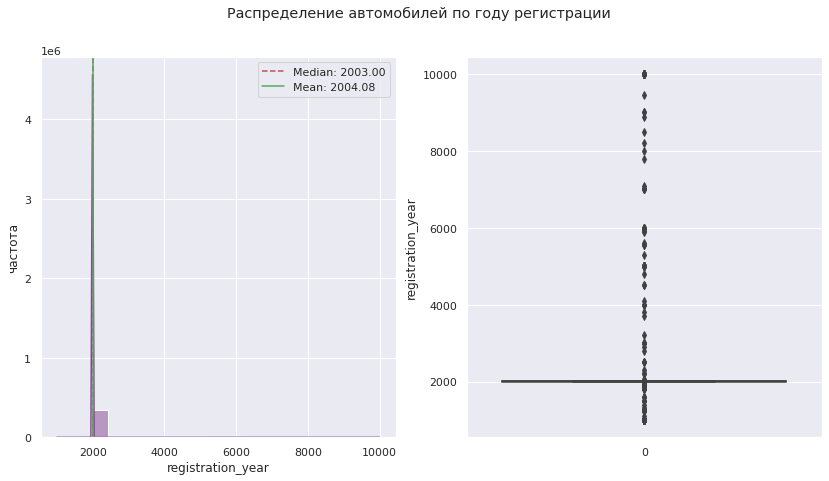

In [35]:
viz_num_character('registration_year', 'Распределение автомобилей по году регистрации', 19)

Имеем аномальные значения - автомобили не могут иметь год регистрации позже даты скачивания анкеты (2016 год) и ранее 1908 года, т.к. первый массовый автомобиль начал выпускаться именно в этом году. Считаем, что в данных мы имеем и раритетные авто с 1908 года. Определим долю аномальных значений от общего числа:

In [36]:
print(f'''Доля автомобилей с годом регистрации позже 2016 года и ранее 1908 года: 
    {(len(df_autos.query('registration_year > 2016 or registration_year < 1908')) / len(df_autos_control)) * 100} %
Количество строк:
    {len(df_autos.query('registration_year > 2016 or registration_year < 1908'))}
    ''')

Доля автомобилей с годом регистрации позже 2016 года и ранее 1908 года: 
    3.8801362421656522 %
Количество строк:
    13750
    


Удаляем аномальные значения (3.88%) из датафрейма:

In [37]:
df_autos = df_autos.query('registration_year <= 2016 and registration_year >= 1908')

df_autos['registration_year'].describe()

count    328192.000000
mean       2002.613053
std           6.877197
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

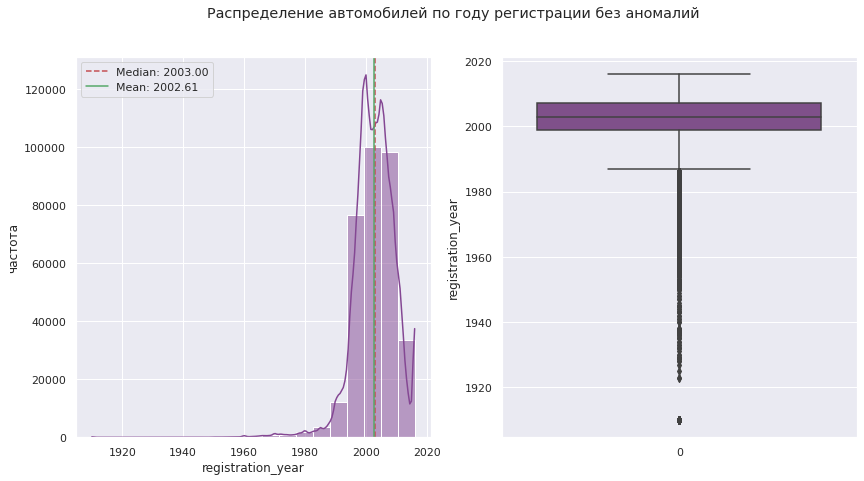

In [38]:
viz_num_character('registration_year', 'Распределение автомобилей по году регистрации без аномалий', 19)

**Вывод**: имеем данные по автомобилям с годом регистрации от 1910 по 2016. Медиана - 2003 год, среднее = 2002 год. С 1990 года заметен значительный рост количества автомобилей. Увеличение доходов населения в развивающихся странах привело к большей покупательской способности, что позволило многим людям приобретать автомобили. Также, развитие дорожной сети и общественного транспорта сделало использование личного автомобиля более удобным и безопасным.

Аномалии (до 1908 и позже 2016 года) удалены из датасета.

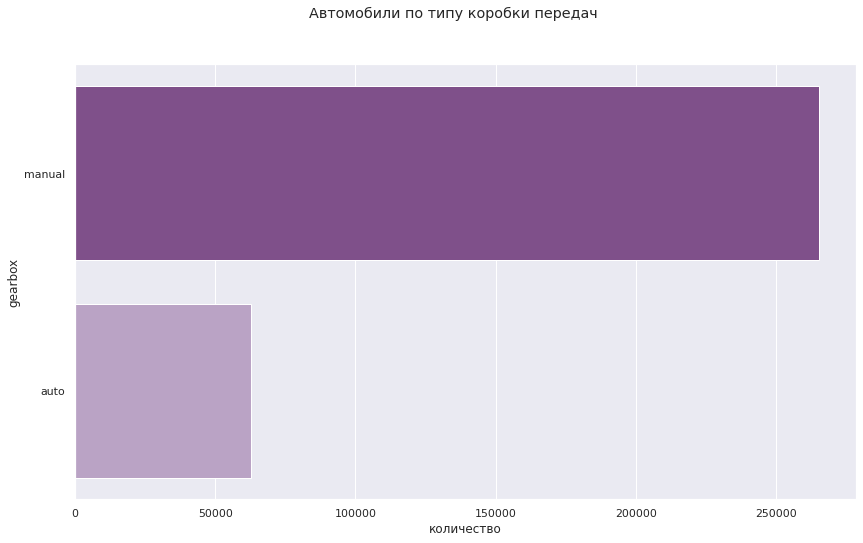

,тип коробки передач,"доля, %"
0,manual,80.855414
1,auto,19.144586


In [39]:
viz_bar_character('gearbox', 'Автомобили по типу коробки передач')

df_autos_gearbox = (df_autos['gearbox'].value_counts(normalize=True) * 100)
df_autos_gearbox.rename_axis('тип коробки передач').reset_index(name='доля, %')

**Вывод**: больше всего автомобилей с механической коробкой передач (80.85%), с автоматической - 19.14%.

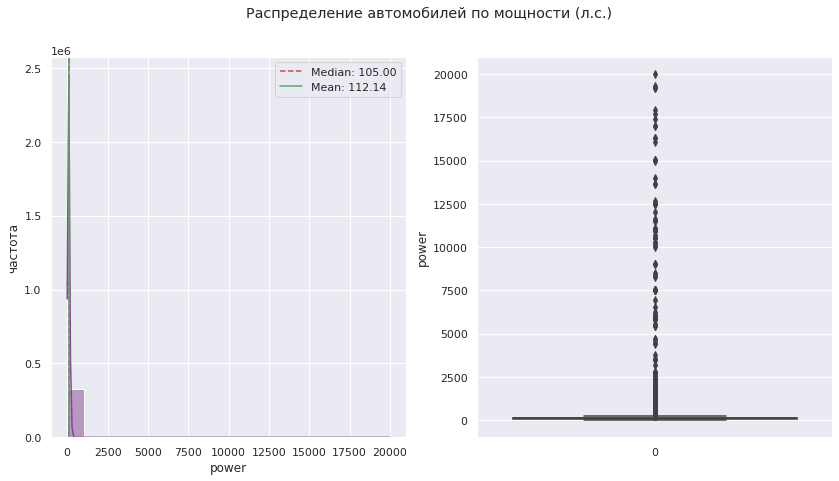

In [40]:
viz_num_character('power', 'Распределение автомобилей по мощности (л.с.)', 19)

Имеем аномальные значения, посмотрим их:

In [41]:
df_autos.query('power == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,yes
15,450,small,1910,manual,0,ka,5000,petrol,ford,yes
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no
37,1500,other,2016,manual,0,kangoo,150000,petrol,renault,no
54,4700,wagon,2005,manual,0,signum,150000,other,opel,no
...,...,...,...,...,...,...,...,...,...,...
354332,3299,other,2005,auto,0,outlander,150000,petrol,mitsubishi,yes
354334,180,other,1995,manual,0,unknown,125000,petrol,opel,yes
354342,2600,other,2005,auto,0,c_klasse,150000,other,mercedes_benz,yes
354359,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


Заменим мощность, равную нулю, на медианное значение по модели автомобиля:

In [42]:
df_autos['power'] = df_autos['power'].replace(0, np.NaN) \
.fillna(df_autos.groupby('model')['power'].transform(lambda x: x.median() if x.median() else np.nan))

print('Проверяем замену. Количество строк, где мощность равна нулю: ', len(df_autos.query('power == 0')))

Проверяем замену. Количество строк, где мощность равна нулю:  0


In [43]:
df_autos.query('power >= 500 or power <=10')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
431,3950,small,2004,auto,5.0,unknown,70000,petrol,sonstige_autos,no
1816,3200,small,2004,manual,1398.0,corolla,5000,petrol,toyota,no
3349,1990,small,2004,manual,7.0,polo,150000,petrol,volkswagen,no
4060,3100,sedan,2005,manual,953.0,colt,150000,petrol,mitsubishi,no
5328,500,wagon,1999,manual,1001.0,astra,150000,petrol,opel,yes
...,...,...,...,...,...,...,...,...,...,...
351943,1500,bus,2001,manual,1001.0,zafira,5000,petrol,opel,no
353123,8600,convertible,2012,manual,8.0,unknown,5000,petrol,sonstige_autos,no
353629,2400,sedan,2007,manual,650.0,c2,150000,petrol,citroen,yes
354256,399,other,1994,manual,1103.0,3er,150000,other,bmw,yes


Считаю данные строки аномалиями, т.к. такие автомобили не могут иметь указанную мощность. Например, Fiat Punto и Сhevrolet Мatiz - это малолитражные автомобили эконом-класса, которые не могут иметь мощность 771 и 603 л.с. соотвественно. Автомобили с мощностью до 10 л.с. не допускаются к использованию на дорогах общего пользования и они практически никогда не выпускались, следовательно, автомобили (согласно данным в датасете) не могут иметь такие значения мощности. Количество строк не так велико, удаляем:

In [44]:
df_autos = df_autos.query('power < 500 and power > 10')

print('Проверяем. Количество строк, где мощность от 10 до 500 л.с.: ', len(df_autos.query('power >= 500 and power <= 10')))

df_autos['power'].describe()

Проверяем. Количество строк, где мощность от 10 до 500 л.с.:  0


count    327548.000000
mean        118.705252
std          52.297490
min          11.000000
25%          75.000000
50%         109.000000
75%         145.000000
max         490.000000
Name: power, dtype: float64

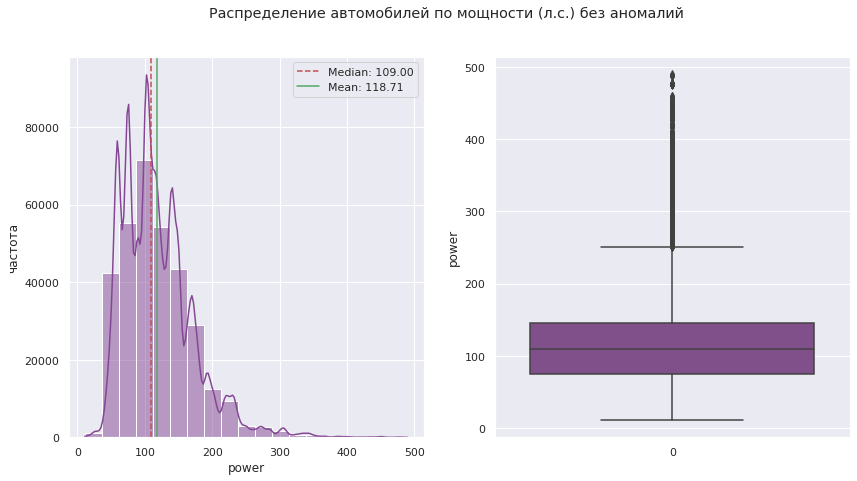

In [45]:
viz_num_character('power', 'Распределение автомобилей по мощности (л.с.) без аномалий', 19)

**Вывод**: средняя мощность автомобилей 118.71 л.с., медиана - 109 л.с. Общее распределение мощности от 11 до 490 л.с. Аномальные значения, где мощность равна нулю, заменены медианой по модели автомобиля, значения от 0 до 10 удалены, значения свыше 500 л.с. - удалены.

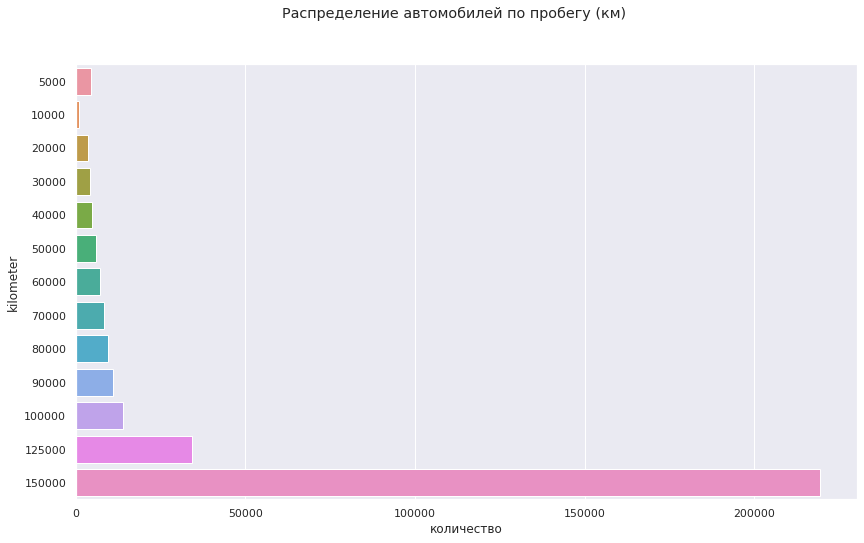

,пробег,"доля, %"
0,150000,66.937365
1,125000,10.468695
2,100000,4.247011
3,90000,3.361339
4,80000,2.924457
5,70000,2.514135
6,60000,2.196319
7,50000,1.820497
8,40000,1.445590
9,5000,1.390025


In [46]:
viz_bar_character('kilometer', 'Распределение автомобилей по пробегу (км)')

df_autos_gearbox = (df_autos['kilometer'].value_counts(normalize=True) * 100)
df_autos_gearbox.rename_axis('пробег').reset_index(name='доля, %')

**Вывод**: у данного признака определить аномалии нет возможности, т.к. пробег автомобиля может быть любым. Данный показатель разбит по категориям. Больше всего автомобилей с пробегом в категории 150000 - почти 67%, меньше всего - категория 10000 - 0.31%.

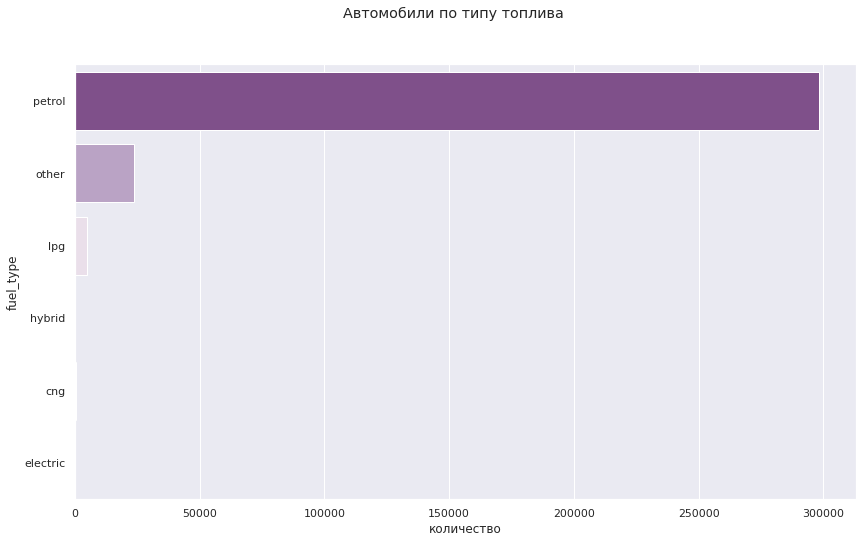

,тип топлива,"доля, %"
0,petrol,91.043755
1,other,7.177269
2,lpg,1.528631
3,cng,0.161198
4,hybrid,0.066860
5,electric,0.022287


In [47]:
viz_bar_character('fuel_type', 'Автомобили по типу топлива')

df_autos_gearbox = (df_autos['fuel_type'].value_counts(normalize=True) * 100)
df_autos_gearbox.rename_axis('тип топлива').reset_index(name='доля, %')

**Вывод**: 91% автомобилей имеем с бензиновой топливной системой. Меньше 1% у гибридной, элетрической и газовой систем.

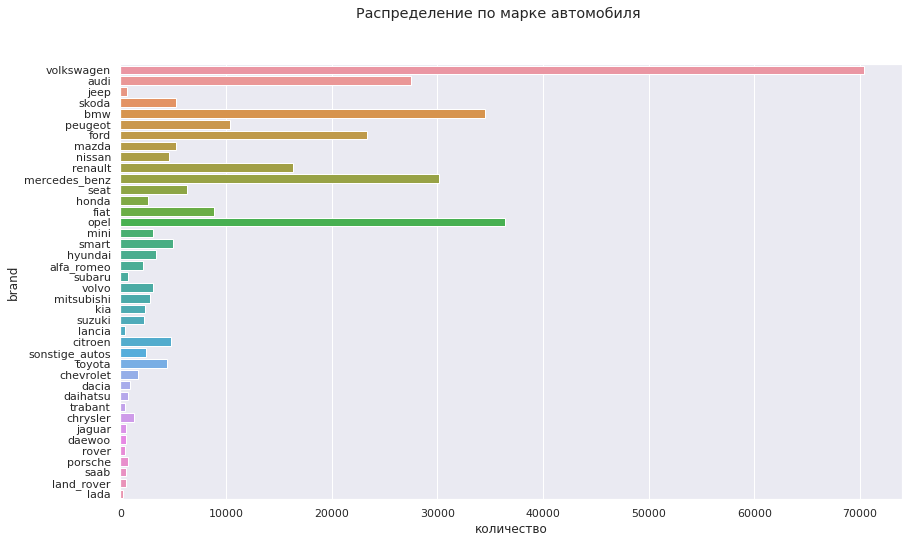

,марка,"доля, %"
0,volkswagen,21.498223
1,opel,11.124476
2,bmw,10.536471
3,mercedes_benz,9.205063
4,audi,8.388694
5,ford,7.137580
6,renault,4.987361
7,peugeot,3.169306
8,fiat,2.695788
9,seat,1.931625


In [48]:
viz_bar_character('brand', 'Распределение по марке автомобиля')

df_autos_gearbox = (df_autos['brand'].value_counts(normalize=True) * 100)
df_autos_gearbox.rename_axis('марка').reset_index(name='доля, %')

**Вывод**: в датасете представлено 40 марок автомобилей. Больше всего (21.5%) - Volkswagen, Opel - 11.12%, BMV - 10.54%. Остальных марок менее 10% на каждую. Менее 0.1% у отечественного производителя - Lada.

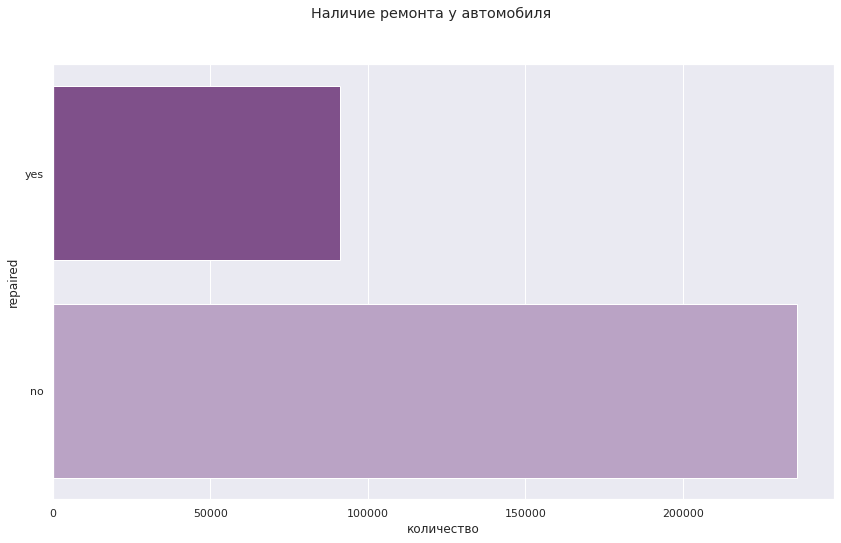

,была в ремонте,"доля, %"
0,no,72.118285
1,yes,27.881715


In [49]:
viz_bar_character('repaired', 'Наличие ремонта у автомобиля')

df_autos_gearbox = (df_autos['repaired'].value_counts(normalize=True) * 100)
df_autos_gearbox.rename_axis('была в ремонте').reset_index(name='доля, %')

**Вывод**: больше всего автомобилей без ремонта - 72%. Подвергались ремонту почти 28% автомобилей.

Проверим долю удаленных данных на этапе EDA:

In [50]:
print(f'''Доля удаленных данных от исходного датасета: 
    {((len(df_autos_control) - len(df_autos)) / len(df_autos_control)) * 100} %
    ''')

# сбросим индексы после всех удалений
df_autos = df_autos.reset_index(drop=True)

# проверим датафрейм после изменений
df_autos.info()

Доля удаленных данных от исходного датасета: 
    7.568664301899997 %
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327548 entries, 0 to 327547
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              327548 non-null  int64  
 1   vehicle_type       327548 non-null  object 
 2   registration_year  327548 non-null  int64  
 3   gearbox            327548 non-null  object 
 4   power              327548 non-null  float64
 5   model              327548 non-null  object 
 6   kilometer          327548 non-null  int64  
 7   fuel_type          327548 non-null  object 
 8   brand              327548 non-null  object 
 9   repaired           327548 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 25.0+ MB


**Вывод**.
**На этапе исследовательского анализа данных было выполнено**:

1. **Созданы функции для визуализации признаков**:
   - гистограмма, диаграмма размаха для количественных непрерывных признаков;
   - столбчатая диаграмма для категориальных признаков и дискретных количественных.


2. **Проведен статистический анализ признаков**. Обнаружены аномалии в значениях:
   - 'price' - цена (целевой признак). Строки со значениями до 50 евро удалены;
   - 'registration_year' - год регистрации автомобиля. Автомобилей с годом регистрации позже 2016 года и ранее 1908 года удалены;
   - 'power' - мощность автомобиля. Мощность, равную нулю, заменили на медианное значение по модели автомобиля. Остальные значения мощности до 10 и от 500 л.с. удалены.
   
Данные в датасете представлены об автомобилях стоимостью от 50 до 20000 евро, средняя цена - 4577.11 евро, медиана - 2900 евро. Больше всего автомобилей с типом кузова седан (sedan) - 26% и хэтчбэки (small) - 22.7%, меньше всего купе (coupe) - 4.55% и внедорожники (suv) - 3.44%. Имеем данные по автомобилям с годом регистрации от 1910 по 2016. С 1990 года заметен значительный рост регистрации автомобилей. Увеличение доходов населения в развивающихся странах привело к большей покупательской способности, что позволило многим людям приобретать автомобили. Также, развитие дорожной сети и общественного транспорта сделало использование личного автомобиля более удобным и безопасным. Больше всего представлено автомобилей с механической коробкой передач (80.85%), с автоматической - 19.14%. Средняя мощность автомобилей 118.71 л.с., медиана - 109 л.с. Общее распределение мощности от 11 до 490 л.с. Наибольшее количество автомобилей с пробегом в категории 150000 - почти 67%, меньше всего - категория 10000 - 0.31%. У 91% автомобилей бензиновая топливная система. Меньше 1% у гибридных, элетрических и газовых систем. В датасете представлено 40 марок автомобилей. Больше всего (21.5%) - Volkswagen, Opel - 11.12%, BMV - 10.54%. Остальных марок менее 10% на каждую. Менее 0.1% у отечественного производителя - Lada. Подвергались ремонту почти 28% автомобилей. 

Доля удаленных данных от исходного датасета: 7.57 %.

### Корреляционный анализ данных

Построим матрицу корреляции признаков датафрейма df_autos и тепловую карту для ее визуализации:

In [51]:
# Вычисление матрицы корреляции с использованием phik
interval_cols = ['registration_year', 'price', 'power']

corr_matrix = df_autos.phik_matrix(interval_cols=interval_cols)
corr_matrix

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.287962,0.583623,0.335589,0.507374,0.573906,0.325344,0.132871,0.364432,0.412496
vehicle_type,0.287962,1.000000,0.174364,0.294468,0.457145,0.906366,0.205399,0.297062,0.624825,0.335283
registration_year,0.583623,0.174364,1.000000,0.076405,0.202782,0.567704,0.334948,0.076154,0.353525,0.219228
gearbox,0.335589,0.294468,0.076405,1.000000,0.584636,0.613213,0.028618,0.124950,0.500942,0.090774
power,0.507374,0.457145,0.202782,0.584636,1.000000,0.796736,0.102476,0.100832,0.579273,0.140516
model,0.573906,0.906366,0.567704,0.613213,0.796736,1.000000,0.437448,0.385129,0.997833,0.243372
kilometer,0.325344,0.205399,0.334948,0.028618,0.102476,0.437448,1.000000,0.126848,0.274660,0.176351
fuel_type,0.132871,0.297062,0.076154,0.124950,0.100832,0.385129,0.126848,1.000000,0.208551,0.291482
brand,0.364432,0.624825,0.353525,0.500942,0.579273,0.997833,0.274660,0.208551,1.000000,0.119100
repaired,0.412496,0.335283,0.219228,0.090774,0.140516,0.243372,0.176351,0.291482,0.119100,1.000000


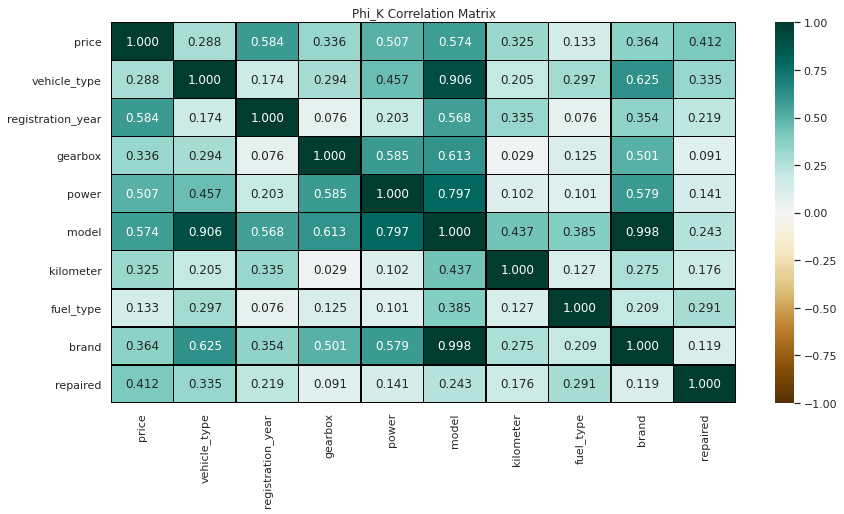

Шкала Чеддока - шкала силы корреляционной связи


In [52]:
# визуализация - тепловая карта
sns.heatmap(corr_matrix, 
                annot=True, vmin=-1, vmax=1, center=0, cmap='BrBG', 
                linecolor='black', linewidths=0.5, fmt=".3f")
sns.set(rc={'figure.figsize': (15, 10)})
plt.title('Phi_K Correlation Matrix')
plt.show()

print('Шкала Чеддока - шкала силы корреляционной связи')
from IPython.display import Image
Image(url='https://intuit.ru/EDI/22_08_23_1/1692656410-28489/tutorial/25/objects/8/files/8_1.gif')

**Вывод**:

Зависимость целевого признака (цена) от входных признаков:
- заметная:
   - модель автомобиля (0.574);
   - мощность (0.507);
   - год регистрации (0.584);
- умеренная:
   - был ремонт автомобиля (0.412);
   - марка автомобиля (0.364);
   - пробег (0.325);
   - тип коробки передач (0.336);
- слабая:
   - тип топлива (0.133);
   - тип кузова (0.288).

### Общий вывод по разделу

**В разделе подготовки данных было выполнено**:

1. **Загрузка данных, изучение информации**.
Импортированы необходимые библиотеки. Загружен файл с данными в датафрейм df_autos, в котором 354369 строк, 16 столбцов. Имелись пропуски, неверные типы данных и некорректная запись названий столбцов.


2. **Предобработка данных**. На данном этапе выполнены:

- Корректировка записи названий столбцов - названия столбцов приведены к "змеиному" регистру;
- Проверка наличия явных дубликатов - явные дубликаты (4 строки) удалены;
- Проверка наличия неявных дубликатов, ошибок: 
   - неявные дубликаты в столбце 'fuel_type' (тип топлива): 'petrol' и 'gasoline' - это два разных названия для одного и того же топлива, бензина ('gasoline' чаще используется в Северной Америке, а 'petrol' - в других странах). Значение 'gasoline' заменено на 'petrol';
   - в столбце 'model' (модель автомобиля) обнаружен неявный дубликат: 'rangerover' и 'range_rover' - это два разных названия для одного и того же. Заменено значение 'rangerover' на 'range_rover';
- Удаление ненужных данных. Для моделирования не требуются такие данные, удалены:
   - date_crawled — дата скачивания анкеты из базы;
   - date_created — дата создания анкеты;
   - number_of_pictures — количество фотографий автомобиля;
   - postal_code — почтовый индекс владельца анкеты (пользователя);
   - registration_month - месяц регистрации автомобиля;
   - last_seen — дата последней активности пользователя.
- Проверка наличия пропущенных значений. В столбцах:
   - 'vehicle_type' - тип кузова. Пропуски заменены на значение 'other';
   - 'gearbox' - тип коробки передач. Пропуски заменены на значение 'manual' как на наиболее часто встречающееся значение;
   - 'model' - модель автомобиля. Пропуски заменены на значение 'unknown';
   - 'fuel_type' - тип топлива. Пропуски заменены на значение 'other';
   - 'repaired' - была машина в ремонте или нет. Пропуски заменены на значение 'yes' - автомобиль был в ремонте, т.к. есть предположение, что владелец автомобиля не захотел "светить" аварийность или прошлые неисправности своего автомобиля, поэтому не заполнил данный пункт в анкете. Т.к. автомобили, бывшие ремонте, ценятся покупателями меньше, т.е. спрос на них снижается, что вызывает понижение цены данного автомобиля.
  


3. **Исследовательский анализ данных**. Выполнено:

- Созданы функции для визуализации признаков:
   - гистограмма, диаграмма размаха для количественных непрерывных признаков;
   - столбчатая диаграмма для категориальных признаков и дискретных количественных.


- Проведен статистический анализ признаков. Обнаружены аномалии в значениях:
   - 'price' - цена (целевой признак). Строки со значениями до 50 евро удалены;
   - 'registration_year' - год регистрации автомобиля. Автомобилей с годом регистрации позже 2016 года и ранее 1908 года удалены;
   - 'power' - мощность автомобиля. Мощность, равную нулю, заменили на медианное значение по модели автомобиля. Остальные значения мощности до 10 и от 500 л.с. удалены.
   
Данные в датасете представлены об автомобилях стоимостью от 50 до 20000 евро, средняя цена - 4577.11 евро, медиана - 2900 евро. Больше всего автомобилей с типом кузова седан (sedan) - 26% и хэтчбэки (small) - 22.7%, меньше всего купе (coupe) - 4.55% и внедорожники (suv) - 3.44%. Имеем данные по автомобилям с годом регистрации от 1910 по 2016. С 1990 года заметен значительный рост регистрации автомобилей. Увеличение доходов населения в развивающихся странах привело к большей покупательской способности, что позволило многим людям приобретать автомобили. Также, развитие дорожной сети и общественного транспорта сделало использование личного автомобиля более удобным и безопасным. Больше всего представлено автомобилей с механической коробкой передач (80.85%), с автоматической - 19.14%. Средняя мощность автомобилей 118.71 л.с., медиана - 109 л.с. Общее распределение мощности от 11 до 490 л.с. Наибольшее количество автомобилей с пробегом в категории 150000 - почти 67%, меньше всего - категория 10000 - 0.31%. У 91% автомобилей бензиновая топливная система. Меньше 1% у гибридных, элетрических и газовых систем. В датасете представлено 40 марок автомобилей. Больше всего (21.5%) - Volkswagen, Opel - 11.12%, BMV - 10.54%. Остальных марок менее 10% на каждую. Менее 0.1% у отечественного производителя - Lada. Подвергались ремонту почти 28% автомобилей. 

Доля удаленных данных от исходного датасета: 7.57 %.


4. **Корреляционный анализ данных**. Построена матрица корреляции с использованием phik и тепловая карта для ее визуализации. Согласно шкале Чеддока определена степень зависимости целевого признака от входных: 
- заметная:
   - модель автомобиля (0.574);
   - мощность (0.507);
   - год регистрации (0.584);
- умеренная:
   - был ремонт автомобиля (0.412);
   - марка автомобиля (0.364);
   - пробег (0.325);
   - тип коробки передач (0.336);
- слабая:
   - тип топлива (0.133);
   - тип кузова (0.288).

## Обучение моделей

### Подготовка, деление данных

Преобразуем все строковые типы признаков в категориальный тип, это требуется работы некоторых моделей:

In [53]:
# отбираем признаки
cat_features = list(df_autos.select_dtypes(include='object').columns)

# с помощью цикла меняем тип данных
for cat in cat_features:
    df_autos[cat] = df_autos[cat].astype('category')
    
# проверяем изменения
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327548 entries, 0 to 327547
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              327548 non-null  int64   
 1   vehicle_type       327548 non-null  category
 2   registration_year  327548 non-null  int64   
 3   gearbox            327548 non-null  category
 4   power              327548 non-null  float64 
 5   model              327548 non-null  category
 6   kilometer          327548 non-null  int64   
 7   fuel_type          327548 non-null  category
 8   brand              327548 non-null  category
 9   repaired           327548 non-null  category
dtypes: category(6), float64(1), int64(3)
memory usage: 12.2 MB


Чтобы оценка качества модели была более надёжной, разделим данные на тренировочную (train), тестовую (test) и валидационную (valid) выборки. Размеры тестовой и валидационной выборок обычно равны. Исходные
данные разбиваем в соотношении 3:1:1 (60%, 20%, 20%):

In [54]:
features = df_autos.drop('price', axis=1)
target = df_autos['price']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, 
    target_valid, 
    test_size=0.5, 
    random_state=RANDOM_STATE)

# проверяем разделение на выборки:
print(f'''
Размерность features_train: {features_train.shape}
Размерность features_valid: {features_valid.shape}
Размерность features_test: {features_test.shape}
Размерность target_train: {target_train.shape}
Размерность target_valid: {target_valid.shape}
Размерность target_test: {target_test.shape}
''')


Размерность features_train: (196528, 9)
Размерность features_valid: (65510, 9)
Размерность features_test: (65510, 9)
Размерность target_train: (196528,)
Размерность target_valid: (65510,)
Размерность target_test: (65510,)



### Модель LightGBM

Зададим параметры и включим поиск лучших гиперпараметров:

In [ ]:
def obj_lgbm(trial):
    # задаем параметры
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': 500,
        'verbosity': -1,
    
        # параметры, которые будем отбирать 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)
    }
    
    # обучаем модель
    model_lgb = lgb.LGBMRegressor(**params)
    model_lgb.fit(features_train,
                  target_train,
                  eval_metric='rmse',
                  eval_set=[(features_valid, target_valid)],
                  callbacks=[early_stopping(stopping_rounds=20)])
                  #categorical_feature=cat_features)
    
    preds = model_lgb.predict(features_valid)
    gini = root_mean_squared_error(target_valid, preds)
    return gini

Запускаем поиск гиперпараметров:

In [ ]:
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(obj_lgbm, n_trials=30)

Лучшие гиперпараметры для LightGBM:

In [57]:
best_lgbm = lgb.LGBMRegressor(**study_lgbm.best_params)
best_lgbm

LGBMRegressor(colsample_bytree=0.770371347425082,
              learning_rate=0.03420458236823464, max_depth=15,
              min_child_samples=30, num_leaves=1008,
              subsample=0.5038378442923164)

Обучаем модель на лучших гиперпараметрах:

In [58]:
# включаем счетчик на обучение
start_time = time.time()

best_lgbm.fit(features_train, target_train)

# останавливаем время
end_time = time.time()
train_time_lgb = end_time - start_time

print(f'''Время обучения LightGBM: {train_time_lgb} секунд ''')

Время обучения LightGBM: 86.35858130455017 секунд 


Получим предсказания:

In [59]:
# включаем счетчик на предсказания
start_time = time.time()

y_pred_lgb = best_lgbm.predict(features_valid)

# останавливаем счетчик
end_time = time.time()
predict_time_lgb = end_time - start_time

print(f'''Время предсказания LightGBM: {predict_time_lgb} секунд ''')

Время предсказания LightGBM: 3.442070960998535 секунд 


Оценим качество модели метрикой RMSE на валидационной выборке:

In [60]:
rmse_lgb = root_mean_squared_error(target_valid, y_pred_lgb)

print(f'''RMSE на валидационной выборке LightGBM: {rmse_lgb:.2f} ''')

RMSE на валидационной выборке LightGBM: 1595.57 


**Вывод**: с помощью OptunaSearchCV найдены лучшие гиперпараметры для модели градиентного бустинга LightGBM: 

LGBMRegressor(colsample_bytree=0.770371347425082,
              learning_rate=0.03420458236823464, max_depth=15,
              min_child_samples=30, num_leaves=1008,
              subsample=0.5038378442923164)
              
Время обучения модели с лучшими гиперпараметрами составило 86.36 секунд. Метрика RMSE на валидационной выборке равна 1595.57.

### Модель LinearRegression

Копируем выборки с признаками для обработки:

In [204]:
features_train_scaler_ohe = features_train.copy()
features_valid_scaler_ohe = features_valid.copy()
features_test_scaler_ohe = features_test.copy()

Масштабируем количественные признаки:

In [205]:
# отбираем количественные признаки
num_columns = features_train.select_dtypes(exclude=['category']).columns

# инициализируем объект StandardScaler
scaler = StandardScaler()

# масштабируем
features_train_scaler_ohe[num_columns] = scaler.fit_transform(features_train_scaler_ohe[num_columns])

features_valid_scaler_ohe[num_columns] = scaler.transform(features_valid_scaler_ohe[num_columns])

features_test_scaler_ohe[num_columns] = scaler.transform(features_test_scaler_ohe[num_columns])

# проверяем
features_test_scaler_ohe.sample(2)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
125963,sedan,0.492449,manual,1.071433,other,0.580087,petrol,alfa_romeo,no
179410,sedan,0.928578,manual,0.059588,golf,-1.836075,petrol,volkswagen,no


Кодирование осуществляем c помощью OneHotEncoder:

In [206]:
from sklearn.preprocessing import OneHotEncoder
# инициализируем кодировщик
encoder = OneHotEncoder(drop='first', handle_unknown='error')

# отбираем категориальные признаки
cat_col_names = features_train.select_dtypes(include=['category']).columns

# кодируем признаки
features_train_scaler_ohe = encoder.fit_transform(features_train_scaler_ohe[cat_col_names])
features_valid_scaler_ohe = encoder.transform(features_valid_scaler_ohe[cat_col_names])
features_test_scaler_ohe = encoder.transform(features_test_scaler_ohe[cat_col_names])

Обучаем модель:

In [207]:
# включаем счетчик
start_time = time.time()

# инициализируем модель линейной регрессии
model_lr = LinearRegression()

# обучаем модель
model_lr.fit(features_train_scaler_ohe, target_train)

# останавливаем время
end_time = time.time()
train_time_lr = end_time - start_time

print(f'''Время обучения LinearRegression: {train_time_lr} секунд ''')

# рассчитываем метрику RMSE на кросс-валидации
rmse_train_lr = abs(cross_val_score(model_lr, features_train_scaler_ohe, 
                                    target_train, cv=5, 
                                    scoring='neg_root_mean_squared_error').mean())

print(f'''RMSE модели LinearRegression на кросс-валидации: {rmse_train_lr:.2f} ''')

Время обучения LinearRegression: 33.94187784194946 секунд 
RMSE модели LinearRegression на кросс-валидации: 3603.87 


Рассчитаем метрику RMSE на валидационной выборке:

In [208]:
# включаем счетчик
start_time = time.time()

# получаем предсказания
model_lr.predict(features_valid_scaler_ohe)

# останавливаем время
end_time = time.time()
predict_time_lr = end_time - start_time

print(f'''Время предсказания LinearRegression: {predict_time_lr} секунд ''')

Время предсказания LinearRegression: 0.001878499984741211 секунд 


Оценим качество модели метрикой RMSE на валидационной выборке:

In [209]:
# рассчитываем метрику
rmse_lr = root_mean_squared_error(target_valid, model_lr.predict(features_valid_scaler_ohe))

print(f'''RMSE на валидационной выборке LinearRegression: {rmse_lr:.2f} ''')

RMSE на валидационной выборке LinearRegression: 3554.93 


**Вывод**: обучена модель линейной регрессии LinearRegression.

Время обучения составило 32.25 секунд, метрика RMSE на валидационной выборке равна 3554.93. Критерий успеха RMSE < 2500 не достигнут.

## Анализ моделей

Сохраним результаты обучения моделей в таблицу:

In [210]:
df = pd.DataFrame(columns=['LightGBM', 'LinearRegression'])
df.loc['Время обучения (сек)'] = [train_time_lgb, train_time_lr]
df.loc['Время предсказания (сек)'] = [predict_time_lgb, predict_time_lr]
df.loc['Метрика RMSE на валид.выборке'] = [rmse_lgb, rmse_lr]
df

,LightGBM,LinearRegression
Время обучения (сек),86.358581,33.941878
Время предсказания (сек),3.442071,0.001878
Метрика RMSE на валид.выборке,1595.572554,3554.933811


Среди двух моделей - LightGBM и LinearRegression наиболее быстрая по времени обучения и предсказания - LinearRegression, но точность данной модели не высокая. Лучше по качеству предсказаний оказалась модель LightGBM.

Сделаем предсказание на тестовой выборке лучшей моделью - LightGBM и рассчитаем метрику RMSE на тестовых данных:

In [211]:
# включаем счетчик на предсказания
start_time = time.time()

y_pred_lgb_test = best_lgbm.predict(features_test)

# останавливаем счетчик
end_time = time.time()
predict_time_lgb_test = end_time - start_time

print(f'''Время предсказания на тестовых данных LightGBM: {predict_time_lgb_test} секунд ''')

rmse_lgb_test = root_mean_squared_error(target_test, y_pred_lgb_test)

print(f'''RMSE на тестовой выборке LightGBM: {rmse_lgb_test:.2f} ''')

Время предсказания на тестовых данных LightGBM: 3.153353452682495 секунд 
RMSE на тестовой выборке LightGBM: 1592.34 


Создаем функцию для отображения важности признаков:

In [212]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность признаков')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Признак / Важность']
    display(feat_importances)

Отобразим какие признаки наиболее важны для ценообразования автомобилей в лучшей модели LightGBM:

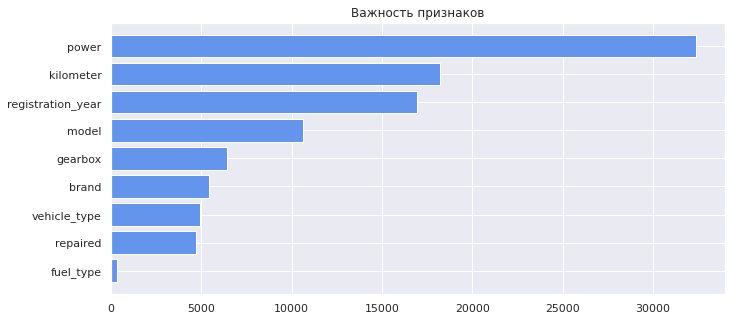

,Признак / Важность
power,32359
kilometer,18233
registration_year,16934
model,10635
gearbox,6391
brand,5436
vehicle_type,4901
repaired,4690
fuel_type,346


In [213]:
importances(best_lgbm, features_train)

Наибольший вклад в ценообразование имеет признак - мощность автомобиля (л.с.), вторым по явлется пробег (км), чуть менее важные - год регистрации, модель и тип коробки передач. А вот тип топливной системы на последнем месте.

## Общий вывод

**РЕАЛИЗАЦИЯ ЗАДАЧИ ПО ЭТАПАМ**:

**ЭТАП 1. Подготовка данных**.

1. **Загрузка данных, изучение информации**.
Импортированы необходимые библиотеки. Загружен файл с данными в датафрейм df_autos, в котором 354369 строк, 16 столбцов. Имелись пропуски, неверные типы данных и некорректная запись названий столбцов.


2. **Предобработка данных**. На данном этапе выполнены:

- Корректировка записи названий столбцов - названия столбцов приведены к "змеиному" регистру;
- Проверка наличия явных дубликатов - явные дубликаты (4 строки) удалены;
- Проверка наличия неявных дубликатов, ошибок: 
   - неявные дубликаты в столбце 'fuel_type' (тип топлива): 'petrol' и 'gasoline' - это два разных названия для одного и того же топлива, бензина ('gasoline' чаще используется в Северной Америке, а 'petrol' - в других странах). Значение 'gasoline' заменено на 'petrol';
   - в столбце 'model' (модель автомобиля) обнаружен неявный дубликат: 'rangerover' и 'range_rover' - это два разных названия для одного и того же. Заменено значение 'rangerover' на 'range_rover';
- Удаление ненужных данных. Для моделирования не требуются такие данные, удалены:
   - date_crawled — дата скачивания анкеты из базы;
   - date_created — дата создания анкеты;
   - number_of_pictures — количество фотографий автомобиля;
   - postal_code — почтовый индекс владельца анкеты (пользователя);
   - registration_month - месяц регистрации автомобиля;
   - last_seen — дата последней активности пользователя.
- Проверка наличия пропущенных значений. В столбцах:
   - 'vehicle_type' - тип кузова. Пропуски заменены на значение 'other';
   - 'gearbox' - тип коробки передач. Пропуски заменены на значение 'manual' как на наиболее часто встречающееся значение;
   - 'model' - модель автомобиля. Пропуски заменены на значение 'unknown';
   - 'fuel_type' - тип топлива. Пропуски заменены на значение 'other';
   - 'repaired' - была машина в ремонте или нет. Пропуски заменены на значение 'yes' - автомобиль был в ремонте, т.к. есть предположение, что владелец автомобиля не захотел "светить" аварийность или прошлые неисправности своего автомобиля, поэтому не заполнил данный пункт в анкете. Т.к. автомобили, бывшие ремонте, ценятся покупателями меньше, т.е. спрос на них снижается, что вызывает понижение цены данного автомобиля.
  


3. **Исследовательский анализ данных**. Выполнено:

- Созданы функции для визуализации признаков:
   - гистограмма, диаграмма размаха для количественных непрерывных признаков;
   - столбчатая диаграмма для категориальных признаков и дискретных количественных.


- Проведен статистический анализ признаков. Обнаружены аномалии в значениях:
   - 'price' - цена (целевой признак). Строки со значениями до 50 евро удалены;
   - 'registration_year' - год регистрации автомобиля. Автомобилей с годом регистрации позже 2016 года и ранее 1908 года удалены;
   - 'power' - мощность автомобиля. Мощность, равную нулю, заменили на медианное значение по модели автомобиля. Остальные значения мощности до 10 и от 500 л.с. удалены.
   
Данные в датасете представлены об автомобилях стоимостью от 50 до 20000 евро, средняя цена - 4577.11 евро, медиана - 2900 евро. Больше всего автомобилей с типом кузова седан (sedan) - 26% и хэтчбэки (small) - 22.7%, меньше всего купе (coupe) - 4.55% и внедорожники (suv) - 3.44%. Имеем данные по автомобилям с годом регистрации от 1910 по 2016. С 1990 года заметен значительный рост регистрации автомобилей. Увеличение доходов населения в развивающихся странах привело к большей покупательской способности, что позволило многим людям приобретать автомобили. Также, развитие дорожной сети и общественного транспорта сделало использование личного автомобиля более удобным и безопасным. Больше всего представлено автомобилей с механической коробкой передач (80.85%), с автоматической - 19.14%. Средняя мощность автомобилей 118.71 л.с., медиана - 109 л.с. Общее распределение мощности от 11 до 490 л.с. Наибольшее количество автомобилей с пробегом в категории 150000 - почти 67%, меньше всего - категория 10000 - 0.31%. У 91% автомобилей бензиновая топливная система. Меньше 1% у гибридных, элетрических и газовых систем. В датасете представлено 40 марок автомобилей. Больше всего (21.5%) - Volkswagen, Opel - 11.12%, BMV - 10.54%. Остальных марок менее 10% на каждую. Менее 0.1% у отечественного производителя - Lada. Подвергались ремонту почти 28% автомобилей. 

Доля удаленных данных от исходного датасета: 7.57 %.


4. **Корреляционный анализ данных**. Построена матрица корреляции с использованием phik и тепловая карта для ее визуализации. Согласно шкале Чеддока определена степень зависимости целевого признака от входных: 
- заметная:
   - модель автомобиля (0.574);
   - мощность (0.507);
   - год регистрации (0.584);
- умеренная:
   - был ремонт автомобиля (0.412);
   - марка автомобиля (0.364);
   - пробег (0.325);
   - тип коробки передач (0.336);
- слабая:
   - тип топлива (0.133);
   - тип кузова (0.288).
   
**ЭТАП 2. Обучение моделей**.

1. **Подготовка, деление данных**. Преобразованы все строковые типы признаков в категориальный тип. Датасет разделен на выборки:  тренировочную (train), тестовую (test) и валидационную (valid) в соотношении 3:1:1 (60%, 20%, 20%).


2. **Модель LightGBM**. Создание и обучение. С помощью OptunaSearchCV найдены лучшие гиперпараметры для модели градиентного бустинга LightGBM:

LGBMRegressor(colsample_bytree=0.770371347425082, learning_rate=0.03420458236823464, max_depth=15, min_child_samples=30, num_leaves=1008, subsample=0.5038378442923164)

Время обучения модели с лучшими гиперпараметрами составило 86.36 секунд, предсказания - 3.44 секунды. Метрика RMSE на валидационной выборке равна 1595.57.

3. **Модель LinearRegression**. Создание и обучение. Осуществлено масштабирование количественных признаков с помощью StandardScaler, кодирование с помощью OneHotEncoder. 

Время обучения составило 32.25 секунд, предсказания - 0.02 секунд, метрика RMSE на валидационной выборке равна 3554.93. Критерий успеха RMSE < 2500 не достигнут.

**ЭТАП 3. Анализ моделей**. Полученные результаты метрик и времени обучения, предсказания сохранены в общей таблице.  

Среди двух моделей - LightGBM и LinearRegression наиболее быстрая по времени обучения и предсказания - LinearRegression, но точность данной модели не высокая. Лучше по качеству предсказаний оказалась модель LightGBM.

Выбрана **лучшая модель** - LGBMRegressor с гиперпараметрами: colsample_bytree=0.770371347425082, learning_rate=0.03420458236823464, max_depth=15, min_child_samples=30, num_leaves=1008, subsample=0.5038378442923164.

Качество лучшей модели проверено на тестовых данных:
- Время предсказания: 3.13 секунд;
- RMSE: 1592.34.

Создана функция для отображения важности признаков - построение "барплот" и таблицы с важностью признаков.
Наибольший вклад в ценообразование имеет признак - мощность автомобиля (л.с.), вторым по явлется пробег (км), чуть менее важные - год регистрации, модель и тип коробки передач. А вот тип топливной системы на последнем месте.